<div style="text-align: center;">

# Cosmology Computational Project
## 1. Comparing the CMB Power Spectrum of Theory and Data

In this notebook, I will guide you through an analysis of the **ACT_DR5_f150 map**. Our primary objective is to compare the theoretical power spectrum with the power spectrum derived from real data.

This analysis builds on concepts introduced in **Summer School Notebooks 6-7**, while also incorporating knowledge from Notebooks 1-4. Relevant references to these notebooks will be cited throughout the analysis.

Text in <font color='#1c8097'>this color</font> indicates content directly taken from the original notebooks, whereas text in black represents my own words and code (including some code generated by ChatGPT 4o and 1o models)
</div>

<div style="text-align: center;">

# <font color='#1c8097'>1.1 Import constants, CMB functions and define variables </font>

</div>

In [31]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions

!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

<div style="text-align: center;">

## <font color='#1c8097'>1.2 Import ACT_DR5 data and define the pixel size according to header 
In here we read the sky coverage from the ACT DR5 website: https://lambda.gsfc.nasa.gov/product/act/actpol_dr5_coadd_maps_info.html where we read "These are 32-bit float FITS images with shape 43200,10320,3. The first two axes are RA and dec in the Plate Carreé projection, covering the area 180° > RA > -180° and -63° < dec < 23° at 0.5 arcmin resolution.  
</font>
</div>

In [32]:
map = fits.getdata('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
header = fits.getheader('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
ra0 = -180  ## Sky ccoverage of DR5 
ra1 = 180
dec0 = -63
dec1 = 23
Nx= header['NAXIS1']
Ny= header['NAXIS2']
Box_side = 500     # this is the size of the map patches 

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins

map = map[0]  # take the first frame of CMB file

0.5 0.5


<div style="text-align: center;">

# 1.3 Plotting the DR5 map

</div>

map mean: -0.79496956 map rms: 162.88133


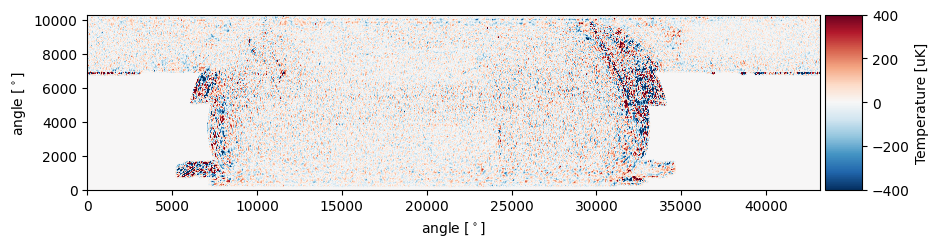

In [33]:
plt.figure(figsize=(20,20))
p = cmb_modules.Plot_CMB_Map(map,c_min,c_max,Nx,Ny)

We see that the CMB map looks homogenous overall but there are some clumpy or overdense region on the boundary and spotted around. This will inspiring the later exploration of $\chi^2$ map in this project.

<div style="text-align: center;">

## 1.4 Apodize the Map to Eliminate the Edge Effects of 2D FFT

### Why Apodization is Necessary

<font color='#1c8097'>Quote from notebook 4-5 : "The edge effects in FFT arise when there are discontinuities at the boundaries of the input data. These discontinuities introduce spurious high-frequency components, which can appear as ringing or unwanted noise in the frequency domain. Apodization is a technique applied to reduce edge effects in a 2D FFT by smoothly tapering the values of the map to zero near the edges." </font>


### Pedagogical Addition: what is edge effects

In the original notebook, the author did not show what edge effects look like. To make this computational project more pedagogical, I will generate a clumpy map using Gaussian smoothing, which mimics the appearance of a CMB map (I initially tried using a white noise map, but since the FFT of white noise is also white noise—hence the name—it doesn't illustrate the edge effect well). Then, I will perform the FFT on the smoothed map to show the edge effects


</div>

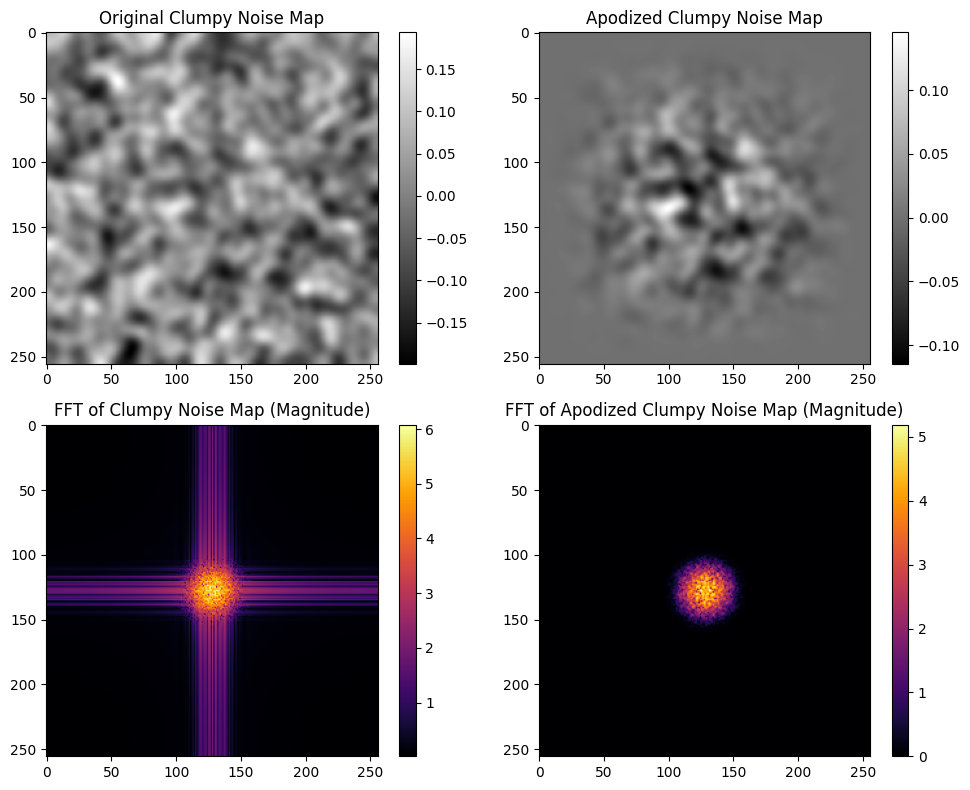

In [138]:
from scipy.ndimage import gaussian_filter

# Generate random noise
raw_noise = np.random.normal(0, 1, (size, size))

# Apply Gaussian smoothing to create clumps
clumpy_noise_map = gaussian_filter(raw_noise, sigma=5)

# Apply apodization to the clumpy noise map
apodized_clumpy_noise_map = clumpy_noise_map * apodization_window

# Compute 2D FFT of both clumpy and apodized clumpy noise maps
fft_clumpy_noise = np.fft.fftshift(np.fft.fft2(clumpy_noise_map))
fft_apodized_clumpy_noise = np.fft.fftshift(np.fft.fft2(apodized_clumpy_noise_map))

# Compute magnitudes for visualization
magnitude_clumpy_noise = np.abs(fft_clumpy_noise)
magnitude_apodized_clumpy_noise = np.abs(fft_apodized_clumpy_noise)


# Plot without separate apodization window or excessive subplots
plt.figure(figsize=(10, 8))

# Original clumpy noise map
plt.subplot(2, 2, 1)
plt.title("Original Clumpy Noise Map")
plt.imshow(clumpy_noise_map, cmap='gray')
plt.colorbar()

# Apodized clumpy noise map
plt.subplot(2, 2, 2)
plt.title("Apodized Clumpy Noise Map")
plt.imshow(apodized_clumpy_noise_map, cmap='gray')
plt.colorbar()

# FFT of original clumpy noise map
plt.subplot(2, 2, 3)
plt.title("FFT of Clumpy Noise Map (Magnitude)")
plt.imshow(np.log1p(magnitude_clumpy_noise), cmap='inferno')
plt.colorbar()

# FFT of apodized clumpy noise map
plt.subplot(2, 2, 4)
plt.title("FFT of Apodized Clumpy Noise Map (Magnitude)")
plt.imshow(np.log1p(magnitude_apodized_clumpy_noise), cmap='inferno')
plt.colorbar()

plt.tight_layout()
plt.show()




<div style="text-align: center;">

We can clearly see that the FFT of the original noise map exhibits a cross-shaped feature. This artifact is introduced by the edge effects, extending across the full frequency spectrum. When we perform FFT on the edge of the graph, it behaves like a delta function, and the FFT of a delta function spans a wide range of frequencies.

In contrast, the apodized map on the right-hand side provides the intrinsic frequency map of the Gaussian noise input. The frequencies are well-constrained within a fuzzy spherical shape, demonstrating how apodization effectively mitigates edge effects and reveals the true frequency content of the input data.
</div>

<div style="text-align: center;">


## <font color='#1c8097'>1.5 Now we apply apodization to the real CMB map

 This step prepares us for the power spectrum calculation and ensures we avoid edge effects.</font>
</div>

In [34]:
N=int(500) # take only one dimension
map_patch = map[N:2*int(N), Ny-2*N:Ny-N] #trimming the map down to size

map mean: -1.9485154749790254 map rms: 61.421140056313476


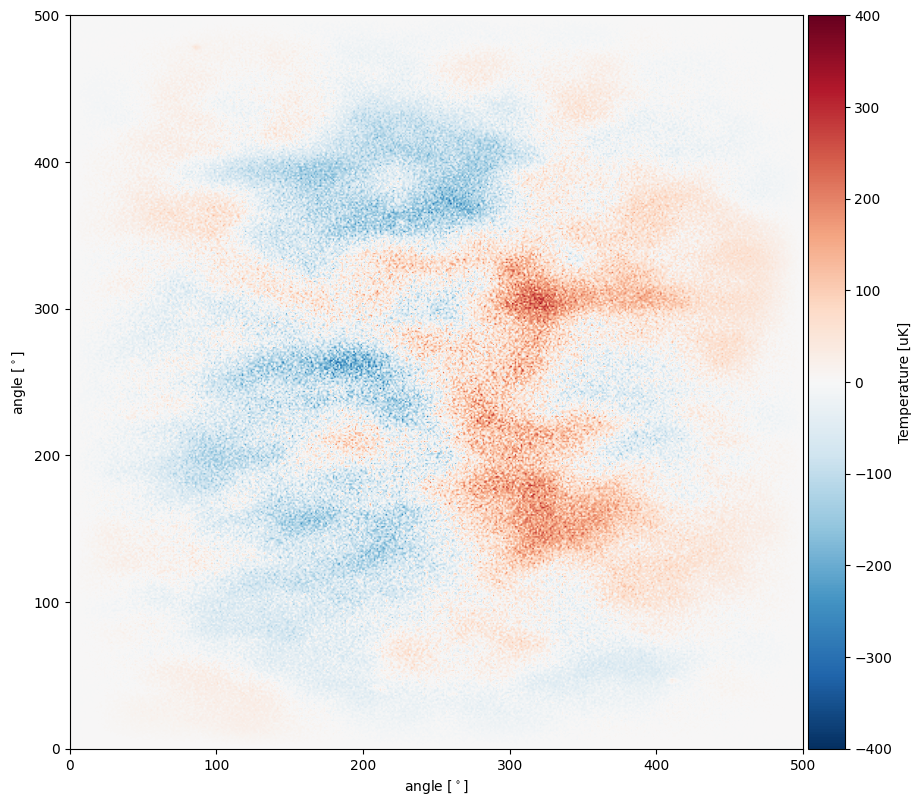

In [35]:
# Making a window function, taking the shorter dimension for now
window = (cmb_modules.cosine_window(N))
appodized_map = window * map_patch
p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)

<div style="text-align: center;">
We see that the edge of the map is replaced by a smooth gradient to zero.
</div>

<div style="text-align: center;">

## <font color='#1c8097'>1.6 Get a modeled CMB map with point source, SZ map, noise, and convoled with insrument beam 

This step follows the orignal text book

</font>


</div>

Number of sources required:  5000
map mean: -9.814989786455365 map rms: 51.8128012075954


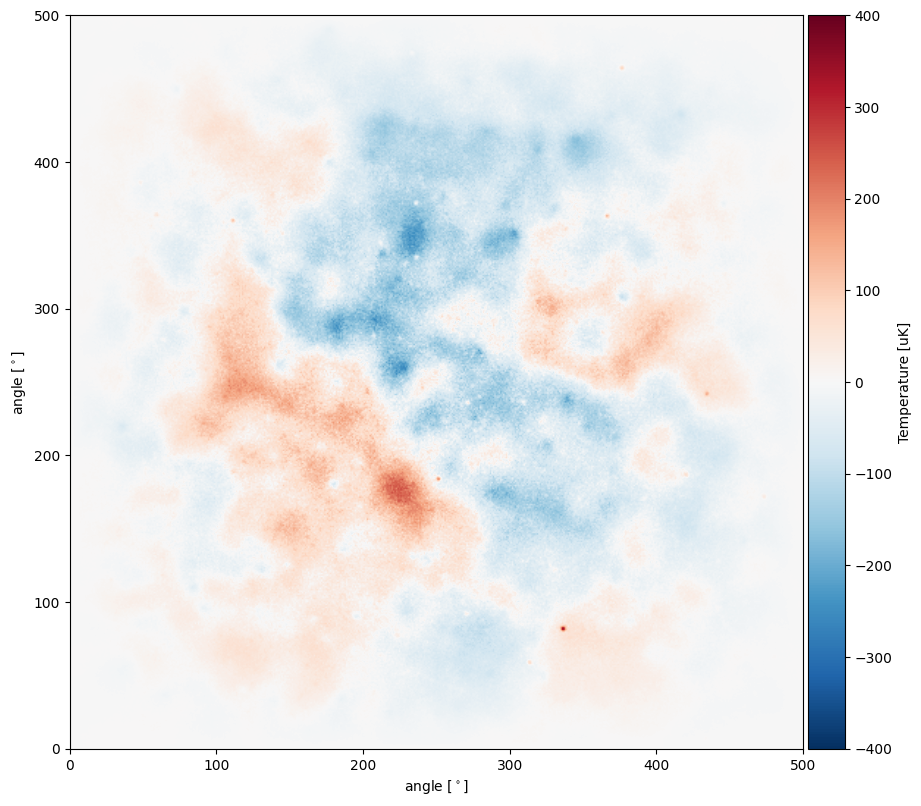

In [36]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = cmb_modules.Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap += cmb_modules.Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = cmb_modules.SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p = cmb_modules.Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p = cmb_modules.Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N)

<div style="text-align: center;">


## <font color='#1c8097'>1.7 Calculate the auto-correlation power spectrum of CMB data and theory </font>

</div>

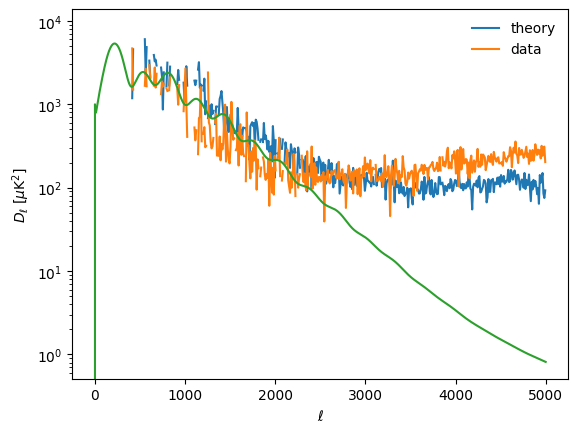

In [37]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<div style="text-align: center;">

We see discrepancy is mainly on large scale. Also some breaking points on large scale has been observed.

</div>

<div style="text-align: center;">


## 1.7 Investigating Discrepancies on Large Scales 

We observe that the discrepancies are primarily on large scales, with some breaking points also occurring on these scales. What happens if we remove the large-scale power before computing the power spectrum? This approach follows Exercise 1 of the original textbook.

In the following cell, I'll filter out the large-scale modes by setting different `ell_min` values. For convenience, I won't use the original `ell` scale directly, but we'll see the correspondence in the later plots.

Additionally, I'll create a pair plot showing both the power spectrum and the CMB map after filtering out the large-scale modes. I expect that as we remove the large-scale modes, the CMB map will become more homogeneous with smaller fluctuations.
</div>

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.fft import fft2, ifft2, fftshift

def filter_large_scale_modes(map_data, ell_min):
    """This function filter out the large scale mode"""
    # Compute the 2D Fourier transform of the input map
    fft_map = fft2(map_data)
    fft_map_shifted = fftshift(fft_map)  # Shift zero frequency to the center

    # Get the dimensions of the map
    ny, nx = map_data.shape
    y, x = np.ogrid[:ny, :nx]
    center_y, center_x = ny // 2, nx // 2

    # Create a mask for filtering out large scale modes
    ell_squared = (x - center_x) ** 2 + (y - center_y) ** 2
    mask = ell_squared >= ell_min**2

    # Apply the mask to filter out large scale modes
    filtered_fft_map_shifted = fft_map_shifted * mask

    # Shift back and perform the inverse FFT to get the filtered map
    filtered_fft_map = ifft2(fftshift(filtered_fft_map_shifted)).real
    return filtered_fft_map

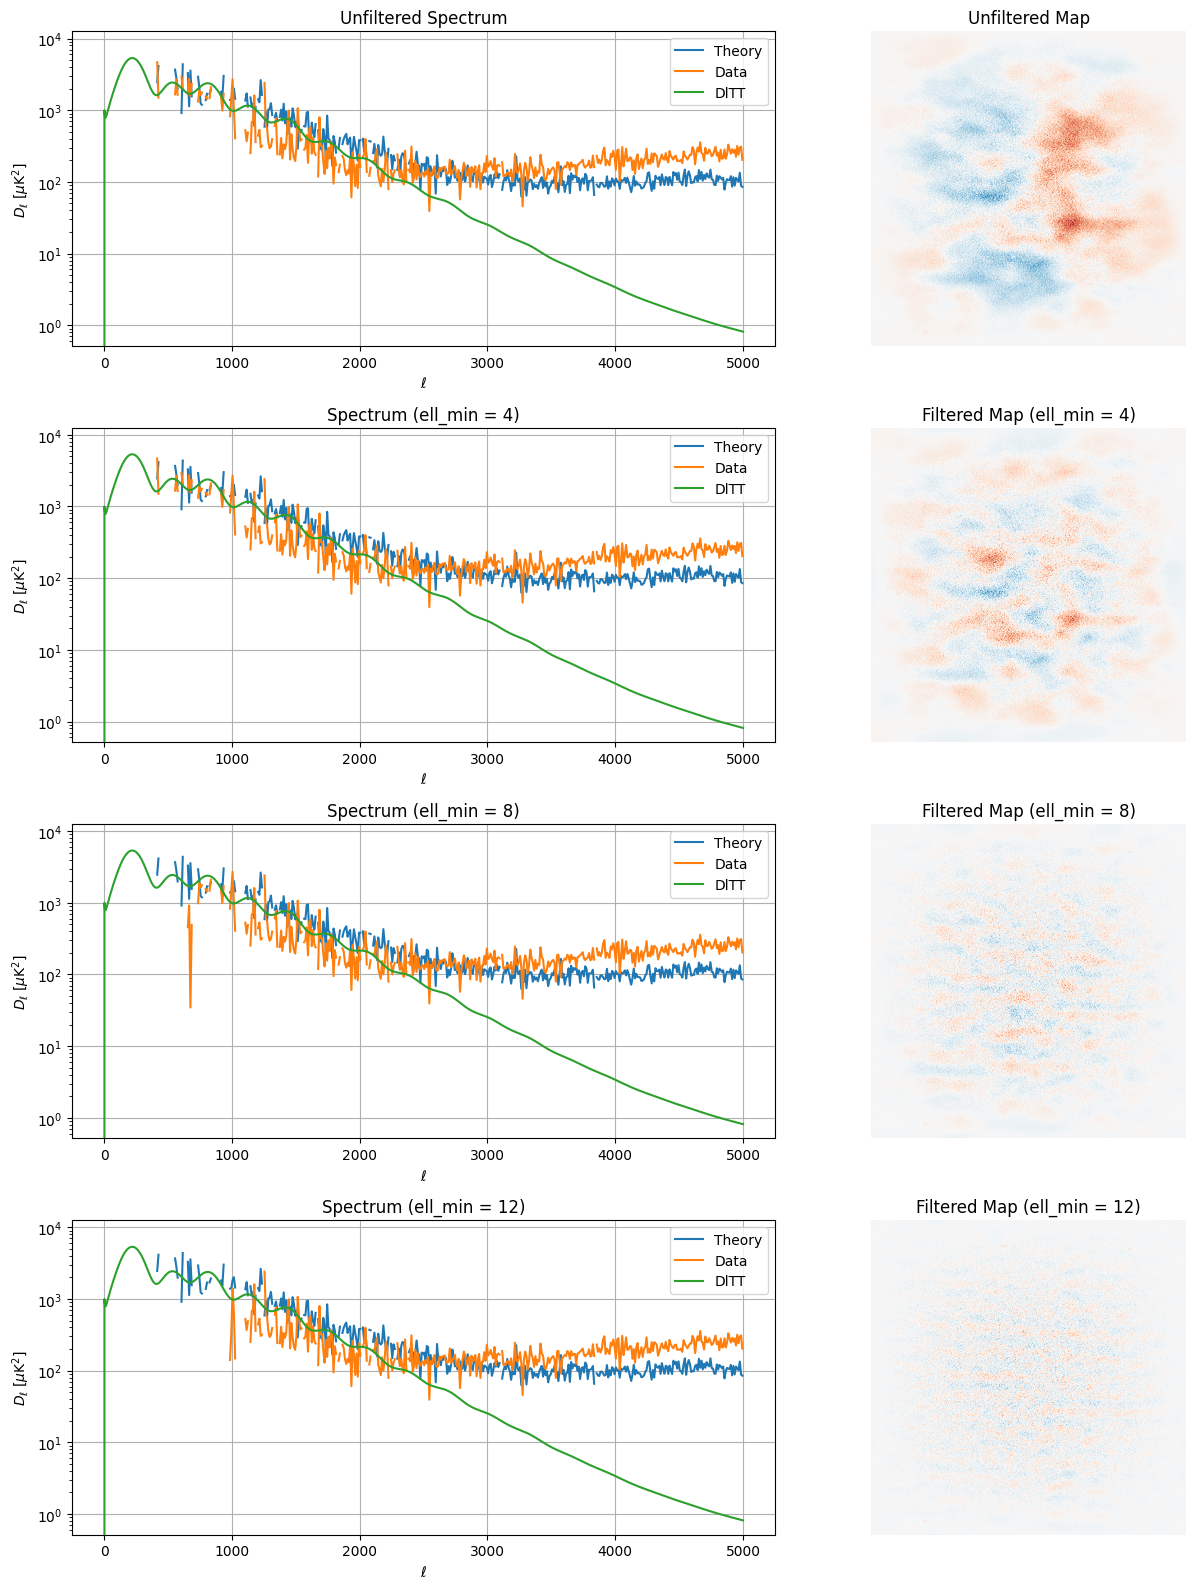

In [16]:
unfiltered_map = appodized_map
# Define a list of ell_min values including 'None' to represent the unfiltered case
ell_min_values = [None, 4, 8, 12]

# Create a figure with two columns: one for the power spectrum and one for the map
fig, axes = plt.subplots(len(ell_min_values), 2, figsize=(14, 4 * len(ell_min_values)))

# Placeholder to store y-axis limits of the unfiltered spectrum
ymin, ymax = None, None

# Loop through each ell_min value to plot spectra and filtered maps
for i, ell_min in enumerate(ell_min_values):
    if ell_min is None:
        filtered_map = unfiltered_map  # Use the original unfiltered map
        title_spectrum = 'Unfiltered Spectrum'
        title_map = 'Unfiltered Map'
    else:
        filtered_map = filter_large_scale_modes(unfiltered_map, ell_min)
        title_spectrum = f'Spectrum (ell_min = {ell_min})'
        title_map = f'Filtered Map (ell_min = {ell_min})'

    # Compute the 2D spectrum using your provided function
    binned_ell_theory, binned_spectrum_theory = cmb_modules.calculate_2d_spectrum(
        appodized_theory_map, appodized_theory_map, delta_ell, ell_max, pix_size, N
    )
    binned_ell_dat, binned_spectrum_dat = cmb_modules.calculate_2d_spectrum(
        filtered_map, filtered_map, delta_ell, ell_max, pix_size, N
    )
    
    # Plot theory and data spectra in the left column
    ax_spectrum = axes[i, 0]
    ax_spectrum.semilogy(binned_ell_theory, binned_spectrum_theory * binned_ell_theory * (binned_ell_theory + 1.) / 2. / np.pi, label='Theory')
    ax_spectrum.semilogy(binned_ell_dat, binned_spectrum_dat * binned_ell_dat * (binned_ell_dat + 1.) / 2. / np.pi, label='Data')
    ax_spectrum.semilogy(ell, DlTT, label='DlTT')
    ax_spectrum.set_title(title_spectrum)
    ax_spectrum.set_xlabel('$\ell$')
    ax_spectrum.set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
    ax_spectrum.legend()
    ax_spectrum.grid()

    # Determine the y-axis limits for the unfiltered spectrum
    if ell_min is None:
        ymin, ymax = ax_spectrum.get_ylim()  # Store the y-axis limits for the unfiltered map
    else:
        # Set the y-axis limits of filtered spectra to match the unfiltered spectrum
        ax_spectrum.set_ylim([ymin, ymax])

    # Plot the filtered map in the right column
    ax_map = axes[i, 1]
    im = ax_map.imshow(filtered_map, cmap=cm.RdBu_r)
    ax_map.set_title(title_map)
    ax_map.axis('off')

plt.tight_layout()
plt.show()


<div style="text-align: center;">
Our guess is correct, as we remove more large scale modes, the CMB map looks more homogenous. And the ell_min=12 in our code is corresponding to ell=1000 in the map, as we can see a clear cut off there. 
</div>

<div style="text-align: center;">


## 1.8 Effects by the shape of the Apodizing Window

There are two types of apodizing windows available: cosine and Gaussian. I aim to investigate how these two window types affect the power spectrum differently.
</div>

/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


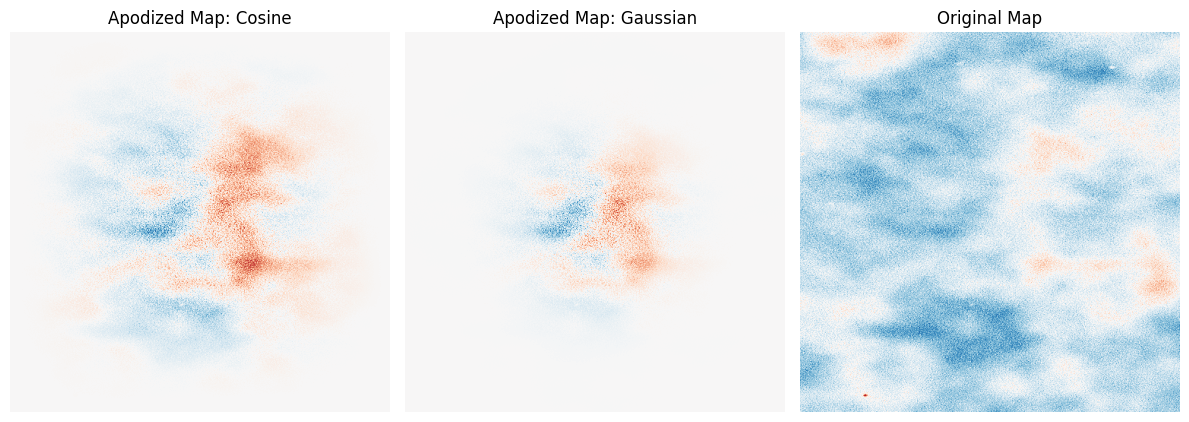

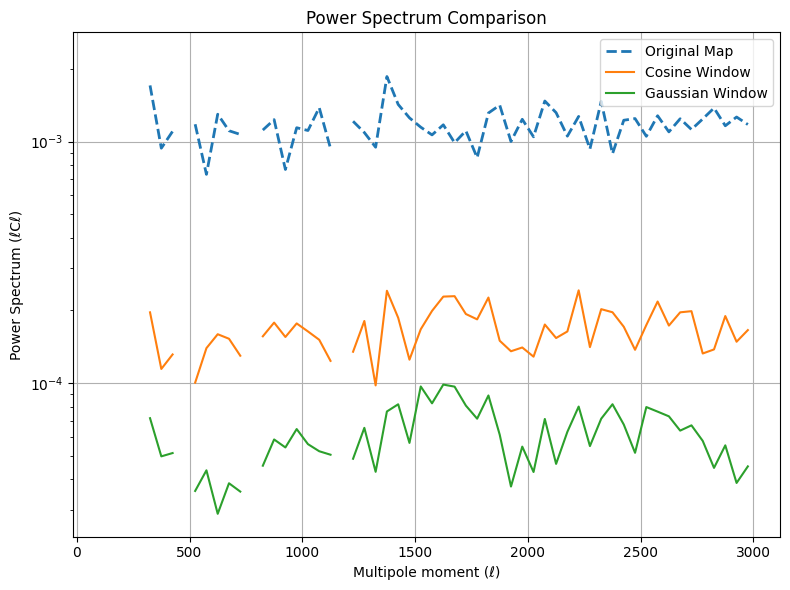

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmb_modules  

unfiltered_map = map_patch
# Function to apply an apodizing window to the map
def apply_apodization(map_data, window_type='cosine'):
    ny, nx = map_data.shape
    y, x = np.ogrid[:ny, :nx]
    
    # Define the apodizing window
    if window_type == 'cosine':
        window_y = 0.5 * (1 - np.cos(2 * np.pi * y / (ny - 1)))
        window_x = 0.5 * (1 - np.cos(2 * np.pi * x / (nx - 1)))
        window = window_y * window_x
    elif window_type == 'gaussian':
        sigma_y = ny / 8.0
        sigma_x = nx / 8.0
        window = np.exp(-((y - ny / 2.0)**2 / (2 * sigma_y**2) + (x - nx / 2.0)**2 / (2 * sigma_x**2)))
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    # Apply the apodizing window to the map
    apodized_map = map_data * window
    return apodized_map

# Parameters for power spectrum calculation
delta_ell = 50
ell_max = 3000
pix_size = 1.5  # Example pixel size in arcminutes
N = 100  # Number of bins

# List of window types to compare
window_types = ['cosine', 'gaussian']

# Original unfiltered map (replace this with your actual map data)
#unfiltered_map = np.random.rand(100, 100)  # Example map data

# Dictionary to store results
power_spectra = {}

# Compute power spectra for each apodization method
for window_type in window_types:
    apodized_map = apply_apodization(unfiltered_map, window_type=window_type)
    ell, ps = cmb_modules.calculate_2d_spectrum(apodized_map,apodized_map, delta_ell, ell_max, pix_size, N)
    power_spectra[window_type] = (ell, ps)

# Compute power spectrum for the original map (no apodization)
ell_original, ps_original = cmb_modules.calculate_2d_spectrum(unfiltered_map,unfiltered_map, delta_ell, ell_max, pix_size, N)

# Plot the maps and their apodized versions
plt.figure(figsize=(12, 5))
for i, window_type in enumerate(window_types):
    apodized_map = apply_apodization(unfiltered_map, window_type=window_type)
    plt.subplot(1, len(window_types) + 1, i + 1)
    plt.imshow(apodized_map, cmap=cm.RdBu_r)
    plt.title(f'Apodized Map: {window_type.capitalize()}')
    plt.axis('off')

# Plot original map as reference
plt.subplot(1, len(window_types) + 1, len(window_types) + 1)
plt.imshow(unfiltered_map, cmap=cm.RdBu_r)
plt.title('Original Map')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot the power spectrum comparison
plt.figure(figsize=(8, 6))
plt.plot(ell_original, ps_original, label='Original Map', linestyle='--', linewidth=2)
for window_type in window_types:
    ell, ps = power_spectra[window_type]
    plt.plot(ell, ps, label=f'{window_type.capitalize()} Window')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multipole moment (ℓ)')
plt.ylabel('Power Spectrum (ℓCℓ)')
plt.title('Power Spectrum Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="text-align: center;">

We observe that the Gaussian window removes more data at the edges compared to the Cosine window. From the power spectrum comparison, we see that higher data loss results in the power spectrum shifting downwards, which is expected. 

Additionally, the Gaussian window shows a greater loss of power on larger scales, which makes sense since the narrower window suppresses large clumps more effectively.
</div>

## 1.9 Power spectrum on different frequencies.
Here, we import and plot the 220GHz map.

map mean: 0.9477959 map rms: 449.8921


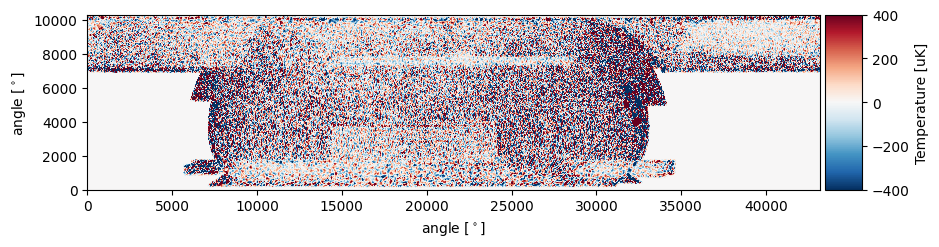

In [20]:
map_220 = fits.getdata('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f220_daynight_map.fits')
map_220 = map_220[0]  # take the first frame of CMB file
plt.figure(figsize=(20,20))
p = cmb_modules.Plot_CMB_Map(map_220,c_min,c_max,Nx,Ny)

Here, we plot the same patch on the sky.

map mean: -4.361716325538631 map rms: 133.51300306403687


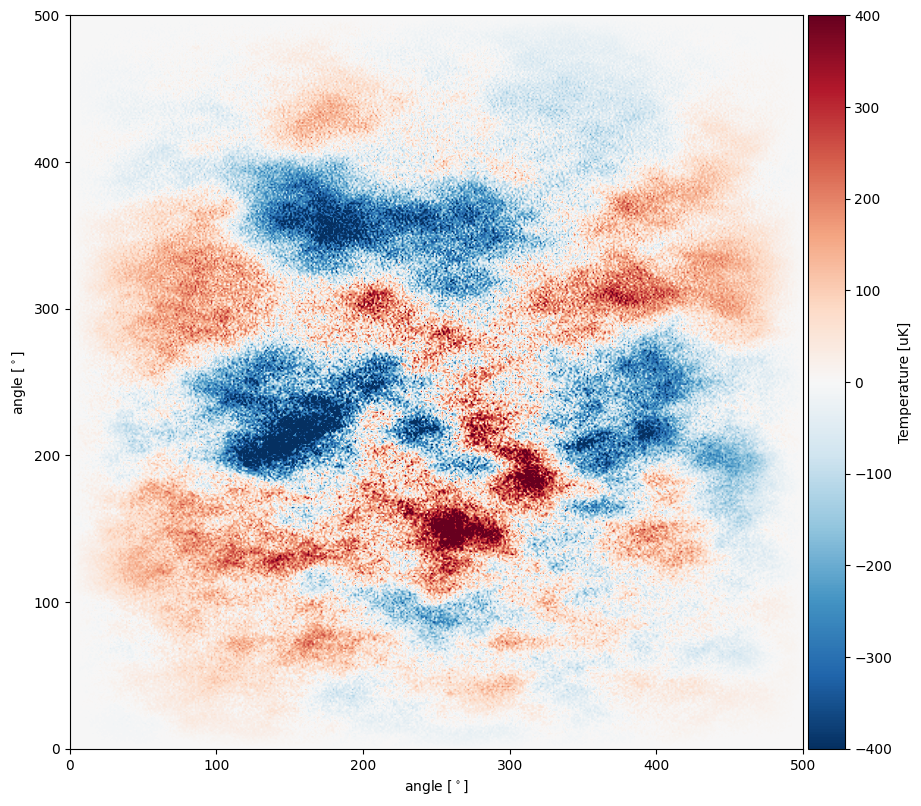

In [21]:
N=int(500) # take only one dimension
map_patch_220 = map_220[N:2*int(N), Ny-2*N:Ny-N] #trimming the map down to size
# Making a window function, taking the shorter dimension for now
window = (cmb_modules.cosine_window(N))
appodized_map_220 = window * map_patch_220
p_220=cmb_modules.Plot_CMB_Map(appodized_map_220,c_min,c_max,N, N)

On the same region, compare to F150 map, F220 map seems have higher contrast. I would expect the power spectrum will also higher.

Then we calculate the power spectrum of 220 map and compare it with the 150 map. 

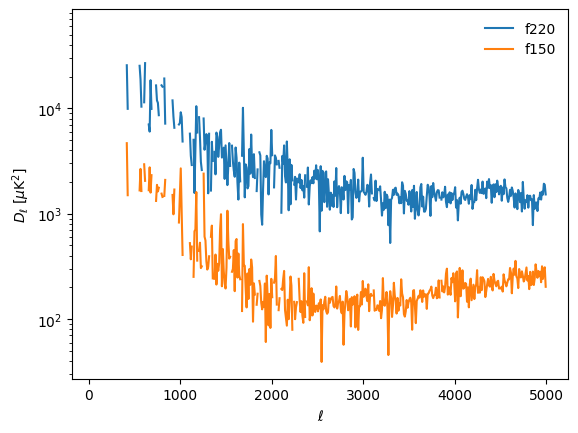

In [55]:

#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

binned_ell_220, binned_spectrum_220 = \
    cmb_modules.calculate_2d_spectrum(appodized_map_220,appodized_map_220,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_220,binned_spectrum_220*\
                 binned_ell_220 * (binned_ell_220+1.)/2. / np.pi, label='f220')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='f150')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
#plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

As we expected, the power spectrum of f220 has higher value on power spectrum, on the the difference is smaller on two ends and larger between ell= 2000 and 3500. 

## 1.10 Cross power spectrum of f150 and f220

So far, we've been working on auto correlated power spectrum, it would be interesting to see the cross correlated power on two different frequencies. 

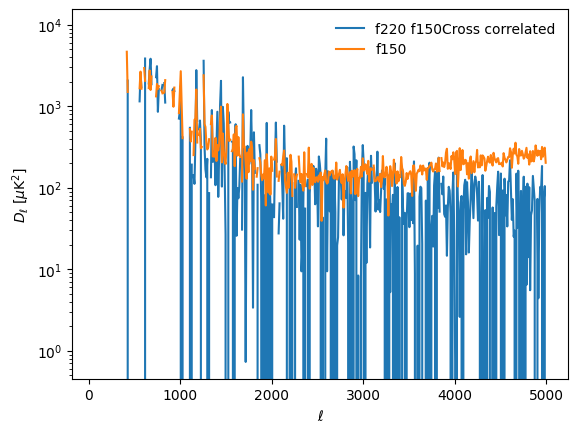

In [56]:

#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

binned_ell_220, binned_spectrum_220 = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map_220, delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_220,binned_spectrum_220*\
                 binned_ell_220 * (binned_ell_220+1.)/2. / np.pi, label='f220 f150Cross correlated')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='f150')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
#plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

This is very noisy ! Then Let's see if we correlate on the same frequency map. We pick two neighbouring 500 box and compare the cross correlated to the auto power spectrum.

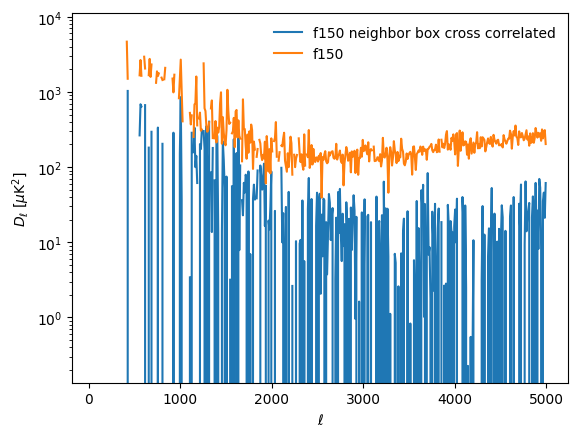

In [57]:
N=int(500) # take only one dimension
map_patch_neibor = map[N+N:2*int(N)+N, Ny-2*N:Ny-N] #shift by N

# Making a window function, taking the shorter dimension for now
window = (cmb_modules.cosine_window(N))
appodized_map_neibor = window * map_patch_neibor
#p_nribor=cmb_modules.Plot_CMB_Map(appodized_map_neibor,c_min,c_max,N, N)

#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

binned_ell_neibor, binned_spectrum_neibor = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map_neibor, delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_neibor,binned_spectrum_neibor*\
                 binned_ell_neibor * (binned_ell_neibor+1.)/2. / np.pi, label='f150 neighbor box cross correlated')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='f150')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
#plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()


It's also very noisy, some data are out of bounds, Let's set an upper and a lower bound to remove the excessive data points, and we can make a more comparible plots.

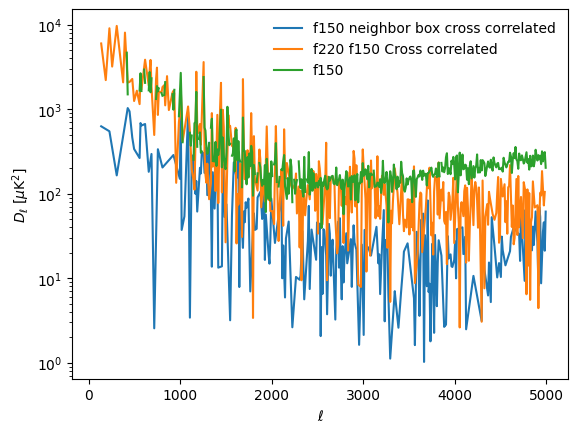

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Example bounds for filtering
y_min, y_max = 1e0, 1e5  # Adjust these bounds as needed for your data

# Filtering function
def filter_data(x, y, y_min, y_max):
    valid_indices = (y * x * (x + 1.) / 2. / np.pi >= y_min) & \
                    (y * x * (x + 1.) / 2. / np.pi <= y_max)
    return x[valid_indices], y[valid_indices]

# Apply filtering to the first dataset
binned_ell_neibor_filtered, binned_spectrum_neibor_filtered = filter_data(
    binned_ell_neibor, binned_spectrum_neibor, y_min, y_max
)

# Apply filtering to the second dataset
binned_ell_220_filtered, binned_spectrum_220_filtered = filter_data(
    binned_ell_220, binned_spectrum_220, y_min, y_max
)

# Plot the filtered data
plt.semilogy(
    binned_ell_neibor_filtered,
    binned_spectrum_neibor_filtered *
    binned_ell_neibor_filtered * (binned_ell_neibor_filtered + 1.) / 2. / np.pi,
    label='f150 neighbor box cross correlated'
)
plt.semilogy(
    binned_ell_220_filtered,
    binned_spectrum_220_filtered *
    binned_ell_220_filtered * (binned_ell_220_filtered + 1.) / 2. / np.pi,
    label='f220 f150 Cross correlated'
)
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='f150')

# Add labels and legend
leg = plt.legend()
leg.draw_frame(False)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()


After setting the bounds to match those of the auto power spectrum limits, we observe a similar power spectrum structure. The neighboring cross correlated power spectrum at the same frequency exhibits lower power compared to the auto power spectrum. This is reasonable, as the regions are not identical, yet they still display a similar shape, reflecting the consistent characteristic features of the CMB across different scales. The cross power spectrum between f220 and f150 shows a comparable amplitude on large scales but diverges on smaller scales, which is expected since the correlation is derived from the same map patch but at different frequencies.

<div style="text-align: center;">

## 2. Using $\chi^2 = \sum_{i} \frac{\left( \text{Data}_i - \text{Theory}_i \right)^2}{\sigma_i^2}$ to Quantify the Discrepancy Between Model and Real Data Power Spectrum

### Motivation

From the earlier plots, we observed that the **ACT_DR5 CMB map** does not exhibit uniform clumpiness across all regions, especially in the circular edge regions. I aim to identify which parts of the map deviate most significantly from the theoretical modeling. 
</div>

<div style="text-align: center;">

### 2.1 Fitting Data and Theory Points with a Polynomial and Resampling to Match Shapes

The power spectrum is inherently noisy, making direct comparisons challenging. To address this, I will first fit both the data and theoretical points using a high-order polynomial. This provides a smooth best-fit line, significantly reducing noise.

After obtaining the polynomial fits, I will resample the data in log space to ensure that both datasets have the same shape. This step is crucial for plugging the data into the $\chi^2$ equation.
</div>

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2


def fit_and_resample_poly(ell_data, C_l_data, ell_theory, C_l_theory, num_points=100):
    """
    Fits the theoretical model to the observed data using polynomial interpolation,
    resamples both datasets to have the same shape, and calculates the Chi-squared statistic.
    
    Parameters:
    - ell_data: Multipole moments for the observed data.
    - C_l_data: Observed power spectrum values.
    - ell_theory: Multipole moments for the theoretical model.
    - C_l_theory: Theoretical power spectrum values.
    - num_points: Number of points for resampling.
    
    Returns:
    - resampled_ell: Resampled ell values.
    - resampled_C_l_data: Resampled observed spectrum.
    - resampled_C_l_fit: Fitted theoretical spectrum.
    - chi_squared: Chi-squared statistic.
    - popt: Optimal parameters from curve fitting.
    """
    # Clean the input data by removing NaNs and Infs
    valid_data_indices = np.isfinite(ell_data) & np.isfinite(C_l_data)
    ell_data = ell_data[valid_data_indices]
    C_l_data = C_l_data[valid_data_indices]
    
    valid_theory_indices = np.isfinite(ell_theory) & np.isfinite(C_l_theory)
    ell_theory = ell_theory[valid_theory_indices]
    C_l_theory = C_l_theory[valid_theory_indices]
    
    # Ensure there's data left after cleaning
    if len(ell_data) == 0 or len(ell_theory) == 0:
        raise ValueError("Cleaned data has no valid entries.")
    
    # Step 2: Define the range for resampling
    min_ell = max(min(ell_data), min(ell_theory))
    max_ell = min(max(ell_data), max(ell_theory))
    resampled_ell = np.linspace(min_ell, max_ell, num_points)
    
    # setting degrees of polynomial, 3 seems okay 
    degree = 5
    # poly fitting 
    theory_coeff = np.polyfit(np.log(ell_theory), np.log(C_l_theory), degree)    # note as the data is showing a log scale, we also have to fitting on a logged data
    data_coeff = np.polyfit(np.log(ell_data), np.log(C_l_data), degree)
    # Generate the polynomial function and resampling 
    theory_poly = np.poly1d(theory_coeff)
    data_poly = np.poly1d(data_coeff)
    resampled_C_l_fit_log = theory_poly(np.log(resampled_ell))
    resampled_C_l_data_log= data_poly(np.log(resampled_ell))
    
    resampled_C_l_fit = np.exp(resampled_C_l_fit_log)
    resampled_C_l_data= np.exp(resampled_C_l_data_log)


    # Step 8: Calculate the Chi-squared statistic
    chi_squared = np.sum(((resampled_C_l_data - resampled_C_l_fit) ** 2) / resampled_C_l_fit)
    
    return resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi_squared


In [14]:
resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_poly(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

<div style="text-align: center;">

# 2.2 Plotting the Raw Data, Fitted Polynomial Curve, and Resampled Data in Pairs

### Motivation

This procedure ensures that the final resampled data is a good representative of the raw data with reduced noise. By plotting the data in pairs, we can verify two key aspects:

1. The fitted polynomial curve closely tracks the raw data, demonstrating that the fit accurately captures the trends in the data despite the noise.
2. The resampled data and theory maintain similar shapes, ensuring the resampled data remains comparable to the theoretical model for subsequent analysis.

</div>

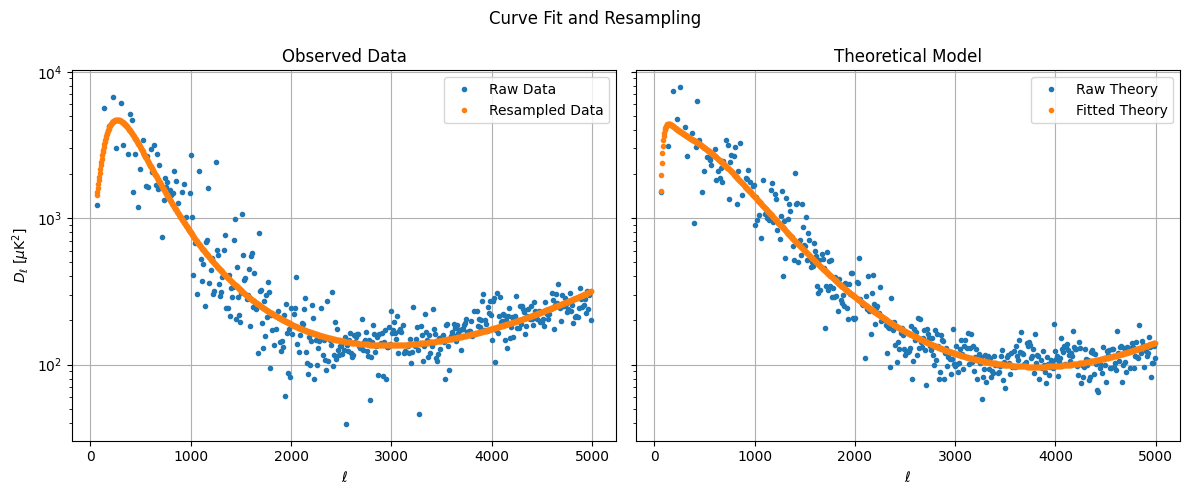

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Observed data
ax1.semilogy(binned_ell_dat, binned_spectrum_dat* binned_ell_dat* (binned_ell_dat + 1.) / 2. / np.pi, '.', label='Raw Data')
ax1.semilogy(resampled_ell, resampled_ell*resampled_C_l_data* (resampled_ell + 1.) / 2. / np.pi, '.', label='Resampled Data')

#ax_spectrum.semilogy(binned_ell_theory, binned_spectrum_theory * binned_ell_theory * (binned_ell_theory + 1.) / 2. / np.pi, label='Theory')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$D_{\ell}$ [$\mu$K$^2$]')
ax1.set_title('Observed Data')
ax1.legend()
ax1.grid(True)

# Plot 2: Theoretical model
ax2.semilogy(binned_ell_theory, binned_spectrum_theory* binned_ell_theory* (binned_ell_theory + 1.) / 2. / np.pi, '.', label='Raw Theory')
ax2.semilogy(resampled_ell, resampled_C_l_fit*resampled_ell* (resampled_ell + 1.) / 2. / np.pi, '.', label='Fitted Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Theoretical Model')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Curve Fit and Resampling')
plt.tight_layout()
plt.show()

<div style="text-align: center;">


### The polynomial fit doing a great job on catching the shape of the data
</div>

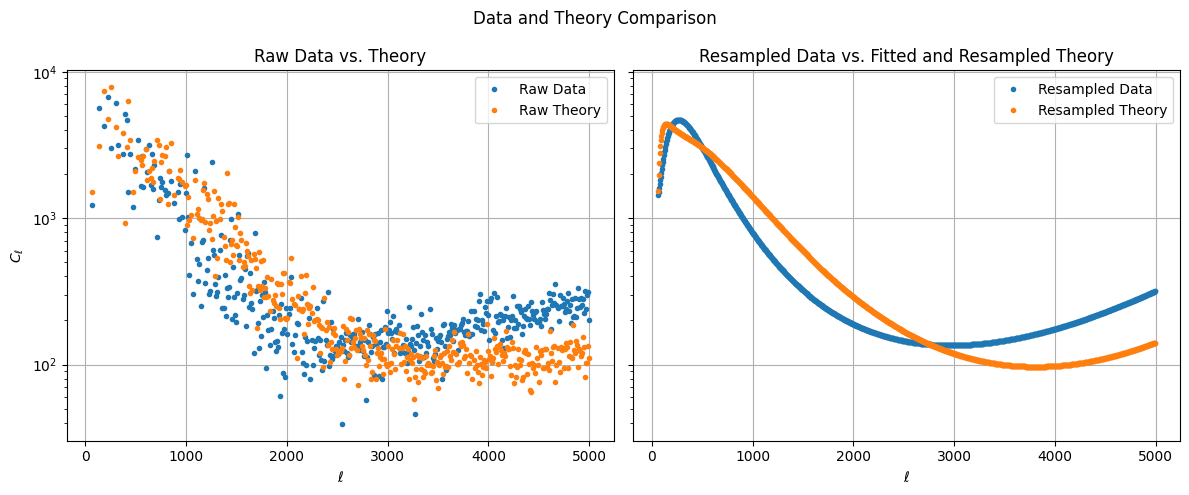

In [18]:
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Raw data vs. raw theory
ax1.semilogy(binned_ell_dat, binned_spectrum_dat* binned_ell_dat* (binned_ell_dat + 1.) / 2. / np.pi, '.', label='Raw Data')
ax1.semilogy(binned_ell_theory, binned_spectrum_theory* binned_ell_theory* (binned_ell_theory + 1.) / 2. / np.pi, '.', label='Raw Theory')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C_\ell$')
ax1.set_title('Raw Data vs. Theory')
ax1.legend()
ax1.grid(True)

# Plot 2: Resampled data vs. resampled fit
ax2.semilogy(resampled_ell, resampled_C_l_data* resampled_ell* (resampled_ell + 1.) / 2. / np.pi, '.', label='Resampled Data')
ax2.semilogy(resampled_ell, resampled_C_l_fit* resampled_ell* (resampled_ell + 1.) / 2. / np.pi, '.', label='Resampled Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Resampled Data vs. Fitted and Resampled Theory')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Data and Theory Comparison')
plt.tight_layout()
plt.show()


<div style="text-align: center;">

The left plot shows the raw data and raw modeling data, while the right plot compares the resampled data and modeling data. 

We observe that the resampled data is a good representative of the raw data, preserving key characteristics such as:
- The cross point at $\ell = 3000$,
- The larger discrepancy at $\ell = 5000$, and
- The discrepancy between $\ell = 1000$ and $\ell = 2000$.
</div>

<div style="text-align: center;">

##  2.3 $\chi^2$ calculation and $\chi^2$ map

### Now we gonna go ahead and calculate the $\chi^2$</div>

In [68]:
def chisquare(i, j, N, Oshift = 0):
    """""This function calculate the chi^2 based on the given corrdinates i, j on the CMB map. N is the patch size or box size"""
    map_patch = map[i*N+Oshift:(i+1)*N+Oshift,j*N+Oshift:(j+1)*N+Oshift] #trimming the map down to size

    # Making a window function, taking the shorter dimension for now
    window = (cmb_modules.cosine_window(N))
    appodized_map = window * map_patch
    #p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)


    #### parameters for setting up the spectrum
    delta_ell = 10# cs.delta_ell
    ell_max = cs.ell_max
    #ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
    #plt.clf()

    if max(ell)< ell_max: 
            print('WARNING: Your theory curves end before the binned ell_max')
            

    # calculate theory and data power spectrum
    binned_ell_theory, binned_spectrum_theory = \
        cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
    binned_ell_dat, binned_spectrum_dat = \
        cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
        
    # get the chi^2 from the function we made earlier
    resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_poly(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

    return chi2
    


<div style="text-align: center;">

make a 2D array which has the same size of DR5 map and divide them into 500*500 squares. We then calculate the $\chi^2$ and store the value into array,
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the map size, I rounded to the 500 
height, width = 10000, 43000

#  Define the size of each square (500 x 500)
square_size = 500
num_rows = (height // square_size ) 
num_cols = (width // square_size ) 

# Create an array to store the computed values for each square
square_values = np.zeros((num_rows, num_cols))

# Loop through the grid and compute a value for each square
for i in range(num_rows):
    for j in range(num_cols):
        # Extract the 500x500 block
        #block = map_data[i * square_size:(i + 1) * square_size,
                        # j * square_size:(j + 1) * square_size]
        # Compute a value (e.g., mean of the block)
        chi2 = chisquare(i, j,square_size)
        square_values[i, j] = chi2
        print(i,j,chi2)

np.savetxt("chisquaremap_ACT_DR5.txt", square_values, delimiter=',', fmt='%.6f')

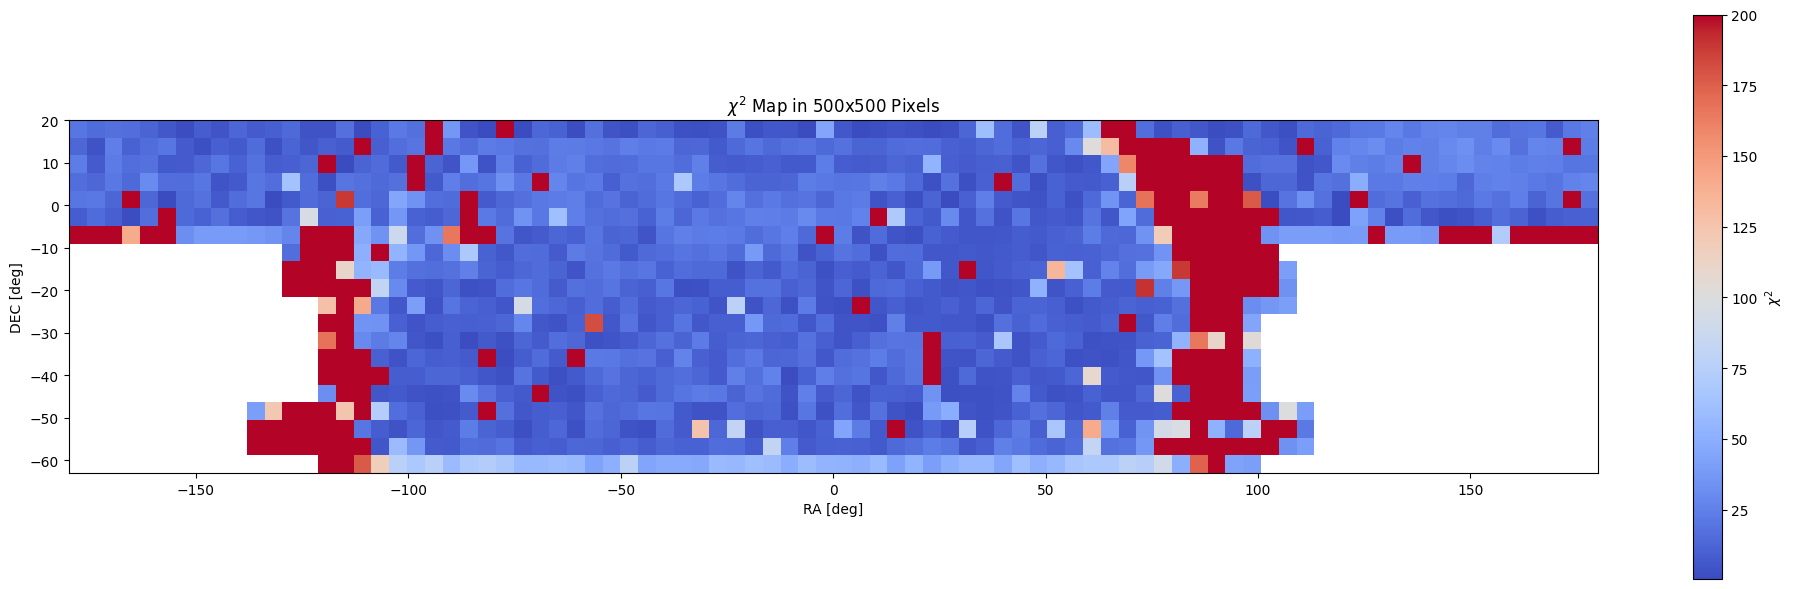

In [78]:
# Set extent for the plot (longitude and latitude ranges)
x_extent = (-180, 180)  # Longitude range (RA)
y_extent = (-63, 20)    # Latitude range (DEC)

# Plot the data with the specified extent
plt.figure(figsize=(20, 6))
plt.imshow(square_values, vmax=200, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
plt.colorbar(label=r'$\chi^2$')  # Add a colorbar with LaTeX formatting for the label
plt.title(r'$\chi^2$ Map in 500x500 Pixels')  # LaTeX formatting for the title
plt.xlabel('RA [deg]')  # Label for x-axis
plt.ylabel('DEC [deg]')  # Label for y-axis
plt.grid(False)  # Disable the grid
plt.tight_layout()  # Adjust layout to fit all components
plt.show()




### Let's plot it together with the CMB map, so we can clear see the comparison

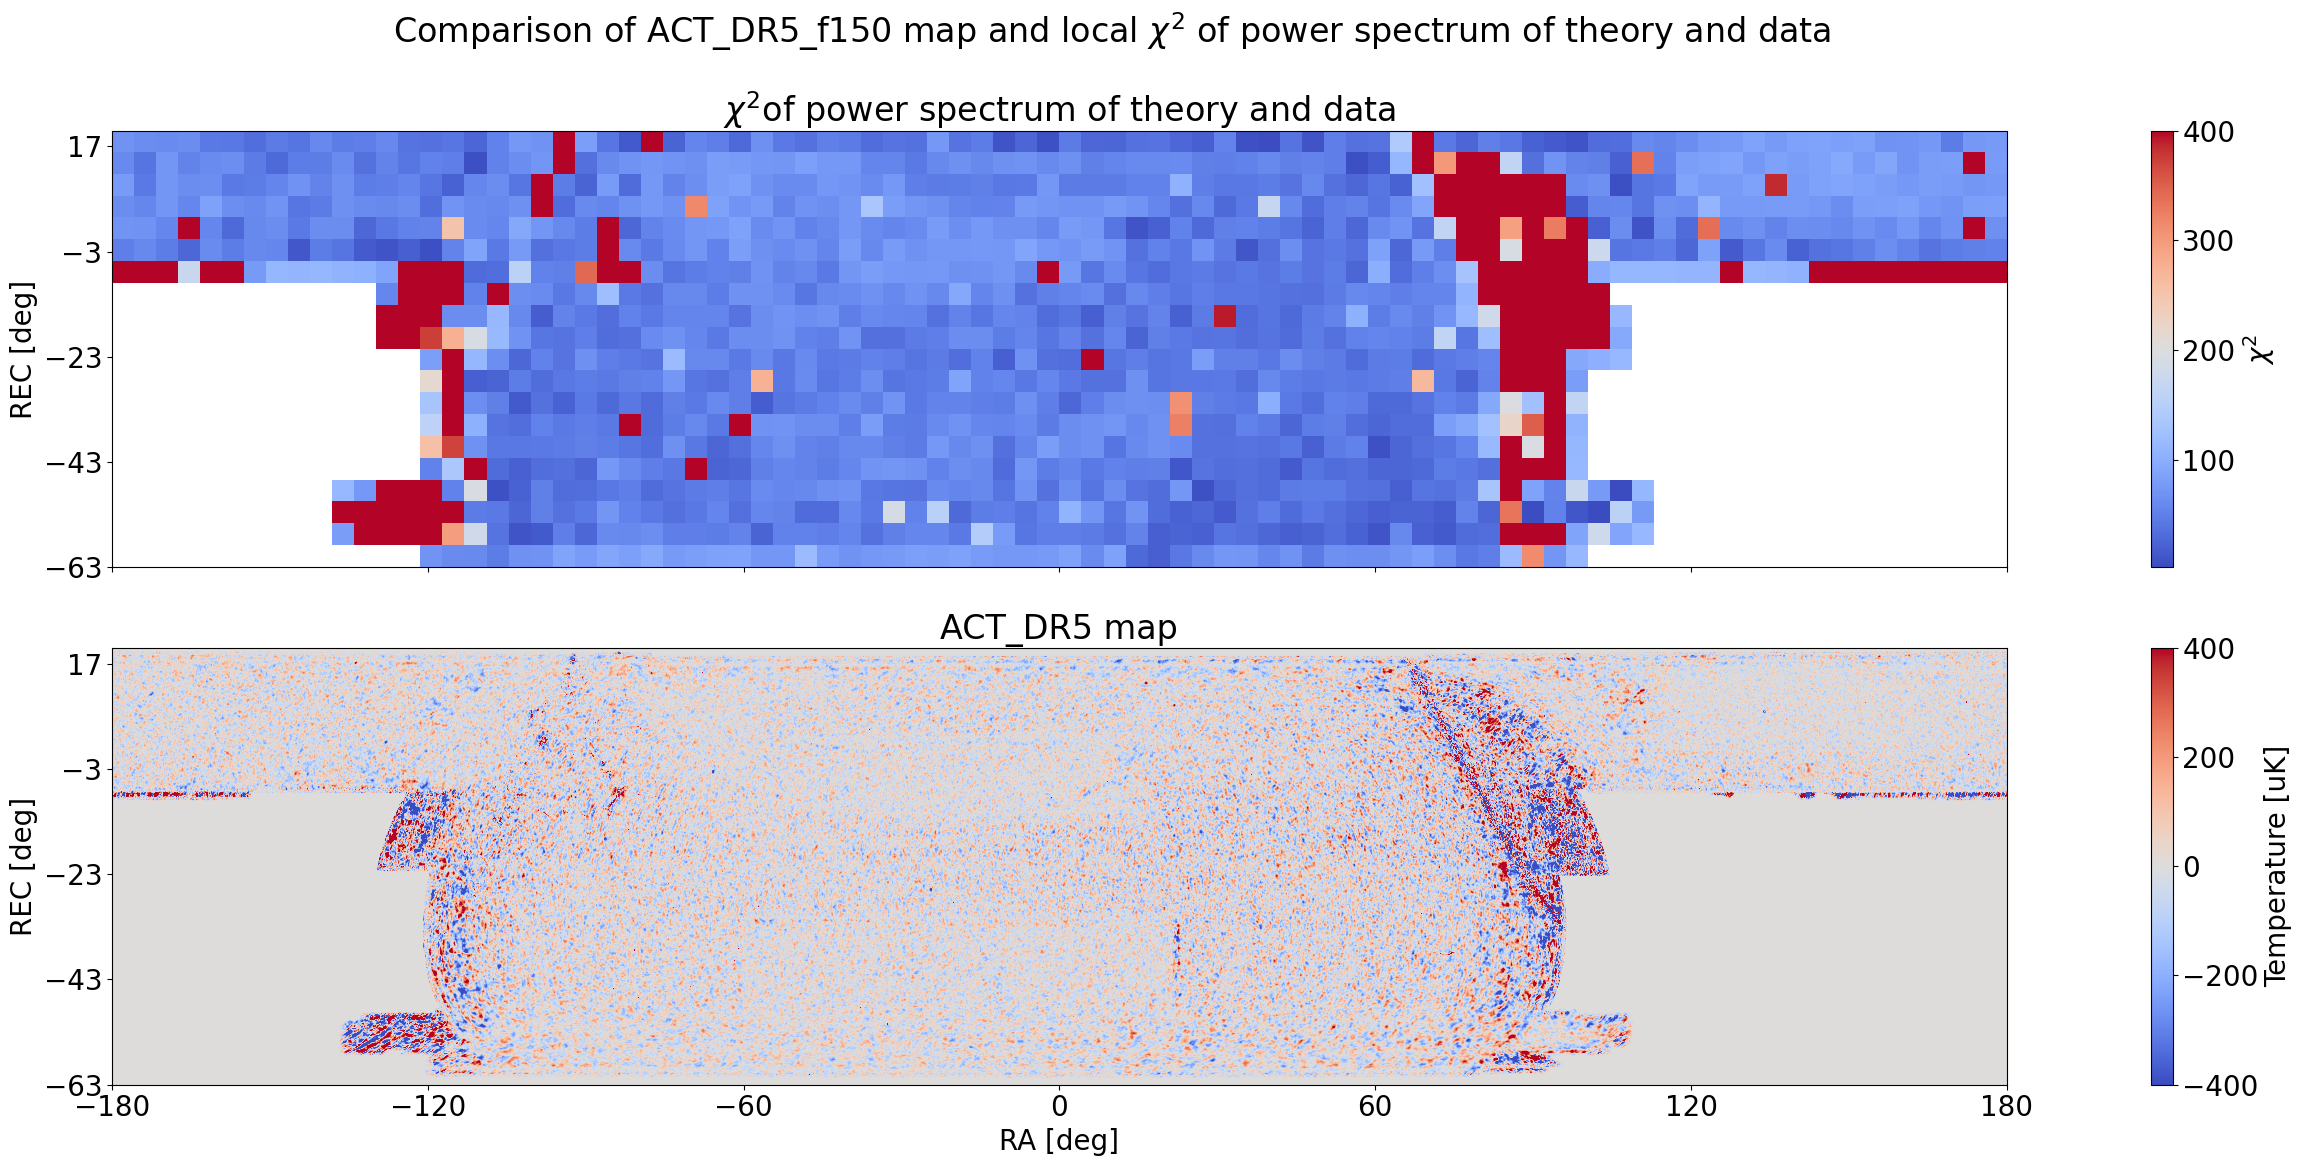

In [170]:

# Define the x and y axis limits
x_extent = (-180, 180)  # Longitude range
y_extent = (-63, 20)    # Latitude range


# Step 2: Define a figure with two subplots side by side, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 12), sharex=True)
plt.rcParams.update({'font.size': 20})
# Step 3: Plot the first map using imshow with shared x-axis
im1 = ax1.imshow(square_values, vmax = 400, cmap='coolwarm', interpolation = 'nearest', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax1.set_title('$\chi^2$of power spectrum of theory and data')
#ax1.set_xlabel('RA')
ax1.set_ylabel('REC [deg]')
plt.colorbar(im1, ax=ax1, orientation='vertical', label="$\chi^2$")

# Step 4: Plot the second map using imshow
im2 = ax2.imshow(map, vmax = 400, vmin = -400, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax2.set_title('ACT_DR5 map')
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('REC [deg]')
plt.colorbar(im2, ax=ax2, orientation='vertical', label="Temperature [uK]")

# Step 5: Set custom x-ticks and y-ticks
x_ticks = np.arange(-180, 181, 60)  # Longitude ticks every 60 degrees
y_ticks = np.arange(-63, 21, 20)    # Latitude ticks from -63 to 20 degrees

for ax in [ax1, ax2]:
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=20)  # Increase tick label font size
ax2.set_xticks(x_ticks)  # Set x-ticks only on the bottom plot
ax2.tick_params(axis='x', labelsize=20)  # Increase x-tick font size

# Step 6: Adjust layout and display the plots
plt.suptitle('Comparison of ACT_DR5_f150 map and local $\chi^2$ of power spectrum of theory and data')
plt.tight_layout()
plt.show()


We see that the $\chi^2 $ map has great correspondance with the CMB map where the higer $\chi^2$ value correspondin to the less homogenous region on the CMB map. 

<div align="center">

# **2.4 Higher Resolution $\chi^2$ Map**

</div>

### **Motivation and potential approaches**

In the following cell, we create a higher resolution $\chi^2$ map. There are two possible approaches to achieve this:

1. **Using Smaller Box Sizes**:
   - Calculate $\chi^2$ using smaller boxes compared to the original size.
   - However, this method introduces significant noise because at smaller scales, the non-linear behavior makes the power spectrum less representative. Recall that the power spectrum is a statistical tool and is most effective on larger scales.

2. **Refining Within the Same Box Size**:
   - Maintain the usual 500x500 box size, as it is widely considered the most representative scale for balancing statistical accuracy and the flat-sky approximation.
   - Instead of representing each $\chi^2$ pixel as a single 500x500 box, we plot a smaller 125x125 box at the center of each. 


### **Advantages of the Second Approach**
1. **Gradient Representation**:
   - By using overlapping smaller boxes, we capture gradients between neighboring $\chi^2$ pixels, with bordering pixels sharing some information.
   - This automatically smooths the map without requiring interpolation.

2. **Edge Effects**:
   - Recall that we previously apodized the patches to reduce edge effects, which involved smoothing the edges to zero.
   - In this process, some edge information is inevitably lost. By plotting smaller $\chi^2$ boxes, we better visualize the size of each $\chi^2$ pixel on the apodized map, offering more clarity about edge behavior.

This refined method balances resolution, statistical reliability, and the flat-sky approximation, providing a more informative visualization of the $\chi^2$ distribution.




### **Proceed with second approach**

In the original map, the information at the apodized region is lost due to the smoothing process. However, when we allow each 500x500 box to overlap with its neighbors, we effectively recover this lost information. Additionally, this approach makes each pixel more representative of the data.

I call this method **CNN patches**, as it resembles how Convolutional Neural Networks (CNNs) convolve signals over overlapping regions.

As demonstrated in the following GIF, the overlapping patches ensure better coverage and representation of the data.


<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif " width="400">
</div>

Firstly we modify the former chisquare function to allow the small step input. 

In [ ]:
def chisquare_highres(i, j, N, step = 125):
    """""This function calculate the chi^2 based on the given corrdinates i, j on the CMB map. N is the patch size or box size"""
    #map_patch = map[i*N:(i+1)*N,j*N:(j+1)*N] #trimming the map down to size
    map_patch = map[i*step:(i+4)*step,j*step:(j+4)*step] #trimming the map down to size
    print(map_patch.shape, i*step,(i+4)*step,j*step,(j+4)*step)
    # Making a window function, taking the shorter dimension for now
    window = (cmb_modules.cosine_window(N))
    appodized_map = window * map_patch
    #p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)


    #### parameters for setting up the spectrum
    delta_ell = 10# cs.delta_ell
    ell_max = cs.ell_max
    #ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
    #plt.clf()

    if max(ell)< ell_max: 
            print('WARNING: Your theory curves end before the binned ell_max')
            

    # calculate theory and data power spectrum
    binned_ell_theory, binned_spectrum_theory = \
        cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
    binned_ell_dat, binned_spectrum_dat = \
        cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
        
    # get the chi^2 from the function we made earlier
    resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_poly(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

    return chi2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the map size, I rounded to the 500 
height, width = 9500, 42500

#  Define the size of each square (500 x 500)
square_size = 500
step_size = square_size//4
num_rows = (height // step_size ) 
num_cols = (width // step_size ) 

# Create an array to store the computed values for each square
square_values = np.zeros((num_rows, num_cols))

# Loop through the grid and compute a value for each square
for i in range(num_rows):
    for j in range(num_cols):
        # Extract the 500x500 block
        #block = map_data[i * square_size:(i + 1) * square_size,
                        # j * square_size:(j + 1) * square_size]
        # Compute a value (e.g., mean of the block)
        chi2 = chisquare_highres(i, j,square_size,step_size)
        square_values[i, j] = chi2
        print(i,j,chi2)

np.savetxt("chisquaremap_ACT_DR5_CNN_125pa.txt", square_values, delimiter=',', fmt='%.6f')

### It took 10 hrs to get calculation done! Cluster required for even higher resolution

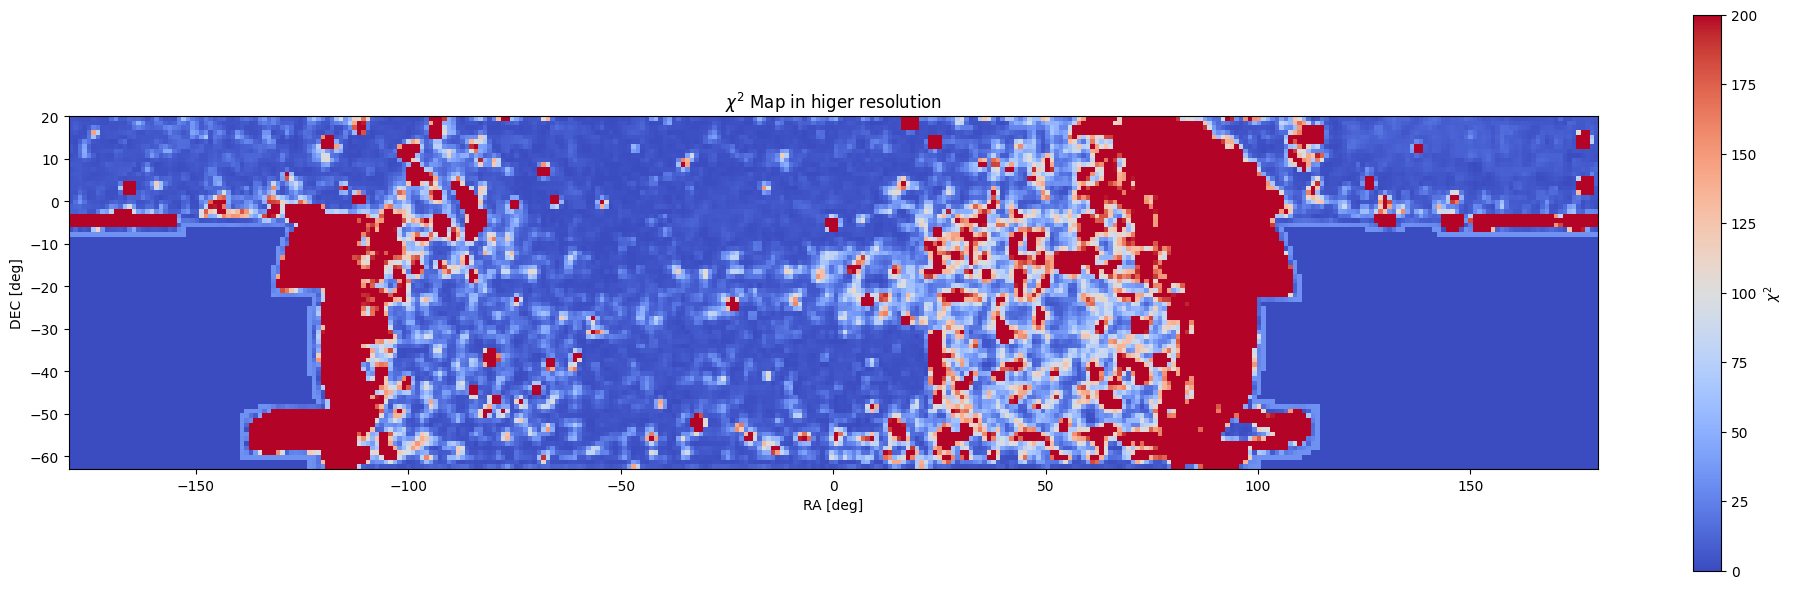

In [80]:
# Path to the text file
file_path = "chisquaremap_ACT_DR5_CNN_125patch.txt"

# Specify the delimiter (adjust as needed, e.g., ',' or '\t')
Hireschi_map = pd.read_csv(file_path, delimiter=',', header=None)  # Replace ',' with your actual delimiter

# Replace NaN values with zero
Hireschi_map = Hireschi_map.fillna(0)

# Convert to NumPy array (optional, if needed for compatibility)
Hireschi_map = Hireschi_map.to_numpy()

# Extract x and y
#x = data[:, 0]  # First column
#y = data[:, 1]  # Second column


# Set extent for the plot (longitude and latitude ranges)
x_extent = (-180, 180)  # Longitude range (RA)
y_extent = (-63, 20)    # Latitude range (DEC)

# Plot the data with the specified extent
plt.figure(figsize=(20, 6))
plt.imshow(Hireschi_map, vmax=200, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
plt.colorbar(label=r'$\chi^2$')  # Add a colorbar with LaTeX formatting for the label
plt.title(r'$\chi^2$ Map in higer resolution')  # LaTeX formatting for the title
plt.xlabel('RA [deg]')  # Label for x-axis
plt.ylabel('DEC [deg]')  # Label for y-axis
plt.grid(False)  # Disable the grid
plt.tight_layout()  # Adjust layout to fit all components
plt.show()


### This indeed gave us a much more detail landscape of the power spectrum $\chi^2$ map of the CMB map . 

<div align="center">

# **3. Conclusion**

</div>

In this project, we explored the application of apodization in power spectrum calculations to reduce edge effects. To demonstrate this pedagogically, we used a lumpy noise map. We then compared the data power spectrum with the theoretical model and observed significant discrepancies on large scales. To address this, we applied a large-scale cut by setting ell_min, which made the CMB map appear more homogeneous. However, we did not identify any tracer of leakage of large-scale power into smaller scales.

Next, we compared different apodization methods, such as cosine and Gaussian windows. These methods introduced a downward shift in the power spectrum due to data loss.

We then proceeded to create a $\chi^2$ map. First, we used a polynomial fit to fit through the theory and data, resampling them into the same shape. Using the 500x500 box size for the submap, the resulting map appeared very pixelated. To improve the map's usability, we implemented a "CNN" mapping approach, generating a much higher resolution map—a process that took 10 hours to compute. The resulting high-resolution $\chi^2$ map corresponded well with the original CMB map, with less homogeneous regions exhibiting significantly higher $\chi^2$ values.


<div align="center">

# **4. Potential Uses of a Chi-Squared Map**

</div>

 **1. Quantifying Goodness-of-Fit Across the Sky**
- The $\chi^2$ value measures how well the observed data agree with the theoretical model.
- A map allows spatial visualization of this agreement:
  - **Low $\chi^2$:** Good fit between data and model.
  - **High $\chi^2$:** Poor fit, indicating potential anomalies.


 **2. Identifying Potential Remaining Foreground Contamination**
- Foreground emissions (e.g., galactic dust, synchrotron radiation, extragalactic sources) can contaminate CMB observations.
- High $\chi^2$  regions possibly align with significant foreground contamination even though the map has been cleaned thoroughly. 
- The map aids in identifying and masking these areas for better cosmological analysis.



 **3. Testing Model Assumptions**
- The $\chi^2$ map reveals whether the theoretical model (e.g., $\Lambda CDM$ ) is globally consistent with the data.
- Persistent patterns of high $\chi^2$ might indicate:
  - Missing parameters.
  - Need for extensions to the model.
  - Potential evidence of new physics? 

 **4. Probing Statistical Isotropy and Homogeneity**
- Cosmology assumes the universe is statistically isotropic and homogeneous.
- A $\chi^2$ map can test these assumptions:
  - Deviations from isotropy or homogeneity manifest as large-scale patterns in $\chi^2$.
  - These findings could highlight cosmic structures or hint at new physics.



